In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
from sklearn.model_selection import train_test_split
from numpy import random
from scipy import linalg

# This script is mainly for POINT B2
# The code for point B1 does not use PYRO and has not been used for the results

# Problem B1.1

In [5]:
# set-up

np.random.seed(0)

def func_g(x):
    return -(np.sin(6*np.pi*x)**2) + 6*x**2 - 5*x**4 + 1.5

l = 30
vec = []
for i in range(1,31):
    xi = (i-1)/(l-1)
    vec.append(xi)
vec = np.array(vec)
finalgrid = np.meshgrid(vec, vec)

yi = func_g(vec) + np.random.normal(0, 0.01, 30)
n = len(yi)

train_indeces = random.choice(range(n), 20, replace=False)
test_indeces = np.setdiff1d(range(n), train_indeces)
x_train = vec[train_indeces]
y_train = yi[train_indeces]

x_test = vec[test_indeces]
y_test = yi[test_indeces]

x = np.linspace(0, 1, 101)
indices = np.where(np.in1d(x, np.round(x_test,2)))[0]

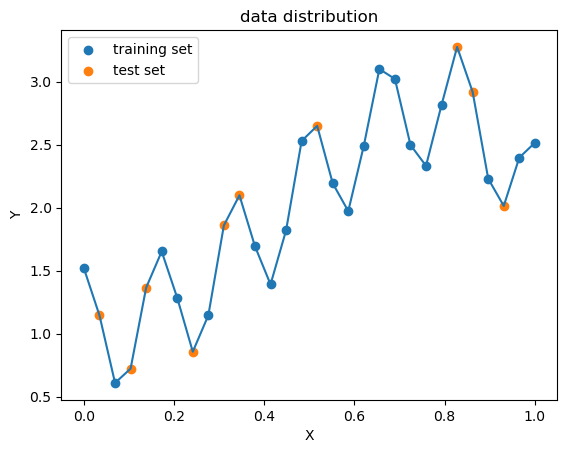

In [6]:
plt.scatter(x_train, y_train, label="training set")
plt.scatter(x_test, y_test, label="test set")
plt.plot(vec, yi)
plt.title("data distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Functions for the kernels, GP process and optimization (with and without prior)

In [7]:
# RBF kernel: params = [sigma]

def exponentiated_quadratic(xa, xb, params):
    """Exponentiated quadratic  with σ=1"""
    sigma = params
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean') / sigma
    return np.exp(sq_norm)

# Periodic kernel: params = [sigma2, l, p]

def periodic(xa, xb, params):
    sigma2, l, p = params[0], params[1], params[2]
    mat = np.zeros((len(xa), len(xb)))
    for i in range(len(xa)):
        for j in range(len(xb)):
            abs = np.abs(xa[i] - xb[j])
            mat[i,j] = abs
    return sigma2 * np.exp(-2/l**2 * (np.sin(np.pi * mat/p)**2))

# Local periodic kernel: params = [sigma2, lp, p, leq]


def local_periodic(xa, xb, params):
    sigma2, lp, p, leq = params[0], params[1], params[2], params[3]
    mat = np.zeros((len(xa), len(xb)))
    norm = scipy.spatial.distance.cdist(xa.reshape(-1,1), xb.reshape(-1,1), 'sqeuclidean')
    for i in range(len(xa)):
        for j in range(len(xb)):
            abs = np.abs(xa[i] - xb[j])
            mat[i,j] = abs
    return sigma2 * np.exp(-2/lp**2 * (np.sin(np.pi * mat/p)**2)) * np.exp(-norm/(2*leq**2))

In [8]:
# Gaussian process posterior with noisy obeservations

def GP_noise(X1, y1, X2, kernel_func, params, noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    n1 = len(X1)
    σ_noise=noise
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1, params) + ((σ_noise ** 2) * np.eye(n1))
    
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, params)
    Σ21 = Σ12.T #kernel_func(X2, X1, params)
     
    # Compute posterior mean
    μ2 = Σ21 @ np.linalg.inv(Σ11) @ y1
    # Compute the posterior covariance
    
    Σ22 = kernel_func(X2, X2, params)
    
    Σ2 = Σ22 - (Σ21 @ np.linalg.inv(Σ11) @ Σ12)
    
    return μ2, Σ2  # mean, covariance

In [9]:
# Likelihood without prior

def negLogLikelihood(params, kernel, S=x_train, y=y_train):
    noise_y = params[0]    
    eta = params[1:]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    K = kernel(S[:, np.newaxis], S[:, np.newaxis], params = eta)
    n = y.shape[0]
     
    observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
    model_complexity = np.log(np.linalg.det(sigma_y_I+K))
    
    ll = -1/2*observed_fit - 1/2*model_complexity 
    if np.isinf(ll):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood

# Optimization procedure

def optimize_params(ranges, kernel, Ngrid):
    opt_params = scipy.optimize.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

# Likelihood with prior - requires means = means = lognorm_mu, vars = lognorm_cov

# Log-prior for the function to maximize
def logprior(p, m, s):
    diff = np.log(p) - m
    return(np.array(-1.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(s)) - np.sum(np.log(p)) - 0.5 * diff @ np.linalg.inv(s) @ diff.T))

def f_to_minimize(params, kernel, means, vars, S = x_train, y = y_train):
    noise_y = params[0]    
    eta = params[1:]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    K = kernel(S[:, np.newaxis], S[:, np.newaxis], params = eta)
    n = y.shape[0]
    
    second_term = logprior(eta, means, vars)
    
    observed_fit = y.T @ scipy.linalg.inv(sigma_y_I + K) @ y
    model_complexity = np.log(np.linalg.det(sigma_y_I + K))
    evidence = -1/2 * observed_fit - 1/2 * model_complexity 
    
    if np.isinf(evidence):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return - evidence - second_term # NEGATIVE loglikelihood

# Corresponding optimization procedure

def optimize_params_second(ranges, kernel, Ngrid, means, vars):
    opt_params = scipy.optimize.brute(lambda params: f_to_minimize(params, kernel, means, vars), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = f_to_minimize(opt_params, kernel, means, vars) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

## Trying the Fit with different kernels

### RBF plain

In [255]:
np.random.seed(0)

# Compute the posterior mean and covariance
sigma = 0.5
σ_noise = 1  # The standard deviation of the noise
domain = (-0.1, 1.1)

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train.reshape(-1,1), y_train, x_test.reshape(-1,1), exponentiated_quadratic, σ_noise, sigma)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2)

# Posterior predictive on R
x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train.reshape(-1,1), y_train, x.reshape(-1,1), exponentiated_quadratic, σ_noise, sigma)
post_pred_RBF_plain = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

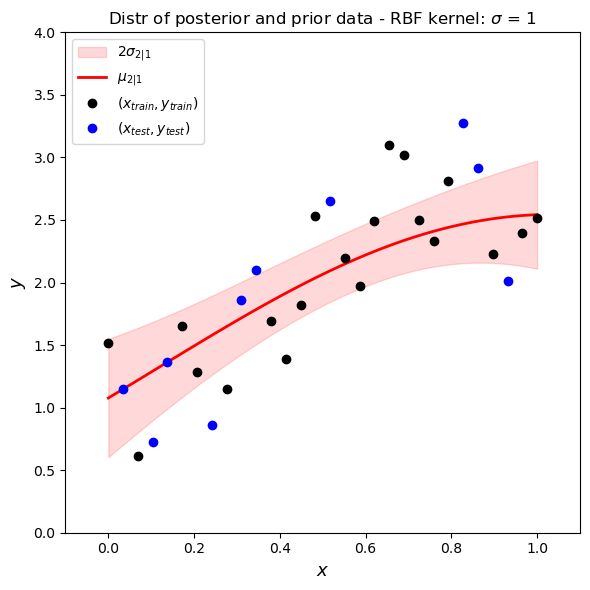

In [257]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(x, post_pred_RBF_plain, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
#ax1.plot(x[indices], post_pred_RBF_plain[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - RBF kernel: $\sigma$ = 1')
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.savefig('gaussian_nonoptimized.png')
plt.show()

### RBF with optimization on $\sigma$

In [258]:
kernel = exponentiated_quadratic
ranges = ((1.e-4,1.e-1), (1.e-4,1))
Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

optimized NLL=-2.447211219154182
optimal params: 0.1 [0.2223]


In [259]:
np.random.seed(0)

opt_par = eta
# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train.reshape(-1,1), y_train, x_test.reshape(-1,1), exponentiated_quadratic, opt_par, noise_var)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some predictions of the posterior
ypredictions_rbf = np.random.multivariate_normal(mean=μ2, cov=Σ2)

# Posterior predictive on R
x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train.reshape(-1,1), y_train, x.reshape(-1,1), exponentiated_quadratic, opt_par, noise_var)
post_pred_RBF = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

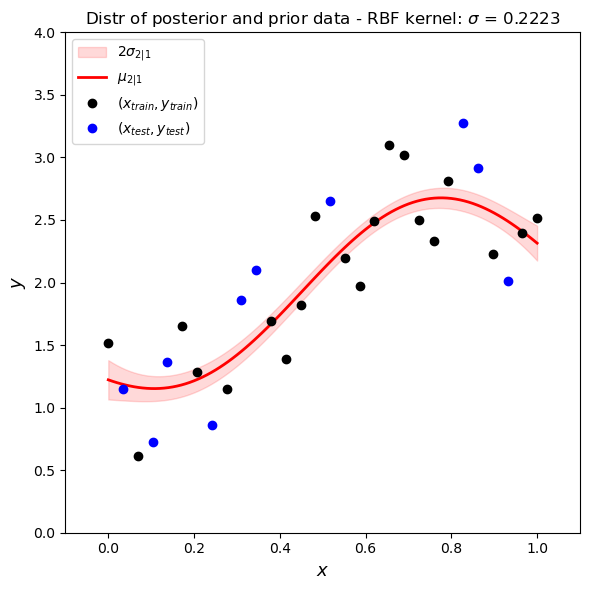

In [261]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(x, post_pred_RBF, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
#ax1.plot(x[indices], post_pred_RBF[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - RBF kernel: $\sigma$ = ' + str(eta[0]))
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.savefig('gaussian_optimized.png')
plt.show()
#

## Periodic Kernel Plain

In [246]:
# Compute the posterior mean and covariance
# [sigma2, l, p]

parameters = [2.33, 4, 1]
σ_noise = 1  # The standard deviation of the noise

domain = (-0.1, 1.1)
# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train, y_train, x_test, periodic, parameters, σ_noise)


# Draw some samples of the posterior
y2_p = np.random.multivariate_normal(mean=μ2, cov=Σ2)

# Posterior predictive on R
x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train, y_train, x, periodic, parameters, σ_noise)
post_pred_periodic_plain = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

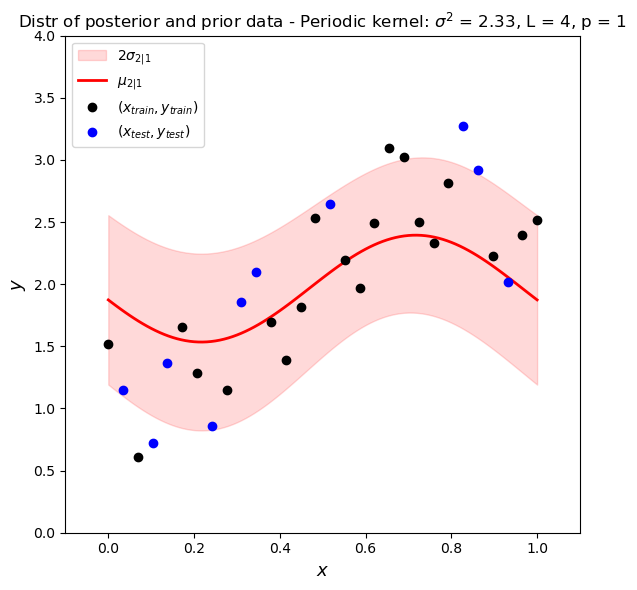

In [249]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(x, post_pred_periodic_plain, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
#ax1.plot(x[indices], post_pred_periodic_plain[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - Periodic kernel: $\sigma^2$ = 2.33, L = 4, p = 1')
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.savefig('Periodic_nonoptimized.png')
plt.show()

## Periodic Kernel - Optimization

In [282]:
#sigma2, l, p 

kernel = periodic
ranges = ((1.e-4,1e-1), (1.e-4,6), (1.e-4,.3), (1.e-4, 6))
Ngrid = 7
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\488410586.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


optimized NLL=-2.4654912574146284
optimal params: 0.0001 [4.00003333 0.10006667 5.00001667]


In [251]:
np.random.seed(0)
opt_par = eta
domain = (-0.1, 1.1)
# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train, y_train, x_test, periodic, opt_par, noise_var)
# Compute the standard deviation at the test points to be plotted
#σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2_periodic = np.random.multivariate_normal(mean=μ2, cov=Σ2)

x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train, y_train, x, periodic, opt_par, noise_var)
post_pred_periodic_opt = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

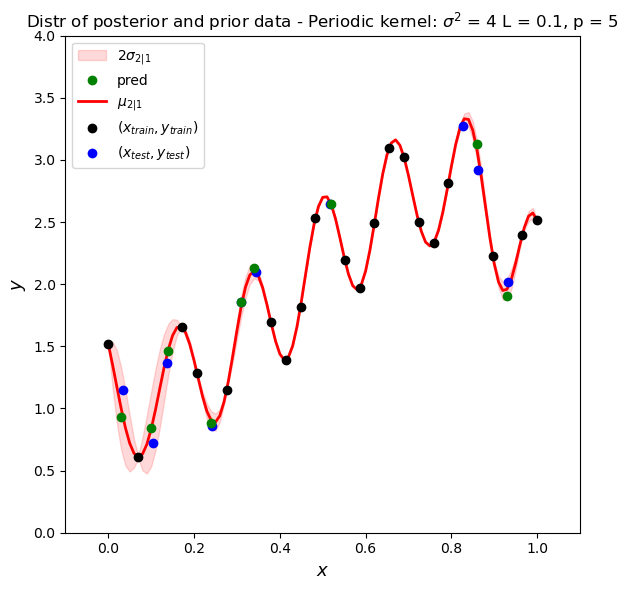

In [252]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(x, post_pred_periodic_opt, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(x[indices], post_pred_periodic_opt[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - Periodic kernel: $\sigma^2$ = ' 
              + str(round(opt_par[0])) + " L = " +str(round(opt_par[1],2))  +", p = " + str(round(opt_par[2])))
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.savefig('Periodic_optimized.png')
plt.show()

In [305]:
# ASSUME LOG-NORMALITY FOR THE FOUR PARAMETERS OF THE LOCAL PERIODIC: sigma2, lp, p, leq

# params of the Normal distribution

mus = np.array([0,0,0])
covmatr  = np.array([[.5, 0, 0],[0, .3, 0],[0, 0, .5]])

norm_par = random.multivariate_normal(mus, covmatr, size=1)

# params of the lognormals:

m_ampl, v_ampl = np.exp(mus[0]+0.5*covmatr[0,0]), np.exp(2*mus[0]+covmatr[0][0])*(np.exp(covmatr[0][0])-1)
m_lp, v_lp = np.exp(mus[1]+0.5*covmatr[1][1]), np.exp(2*mus[1]+covmatr[1][1])*(np.exp(covmatr[1][1])-1)
m_per, v_per = np.exp(mus[2]+0.5*covmatr[2][2]), np.exp(2*mus[2]+covmatr[2][2])*(np.exp(covmatr[2][2])-1)

# Log-normally distributed sample:

parameters = np.exp(norm_par)
lognorm_mu = np.array([m_ampl, m_lp, m_per])
lognorm_cov = np.matrix([[v_ampl, 0, 0],[0, v_lp, 0],[0, 0, v_per]])

In [306]:
#sigma2, l, p 

kernel = periodic
ranges = ((1.e-4,1e-1), (1.e-4,6), (1.e-4,.3), (1.e-4, 6))
Ngrid = 7
noise_var, eta = optimize_params_second(ranges, kernel, Ngrid, lognorm_mu, lognorm_cov)
print("optimal params:", noise_var, eta)

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\1173702511.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


optimized NLL=[[7.76202722]]
optimal params: 0.0001 [4.00003333 0.25001667 2.00006667]


In [308]:
np.random.seed(0)
opt_par = eta
domain = (-0.1, 1.1)
# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train, y_train, x_test, periodic, opt_par, noise_var)
# Compute the standard deviation at the test points to be plotted
#σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2_periodic = np.random.multivariate_normal(mean=μ2, cov=Σ2)

x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train, y_train, x, periodic, opt_par, noise_var)
post_pred_periodic_opt_prior = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

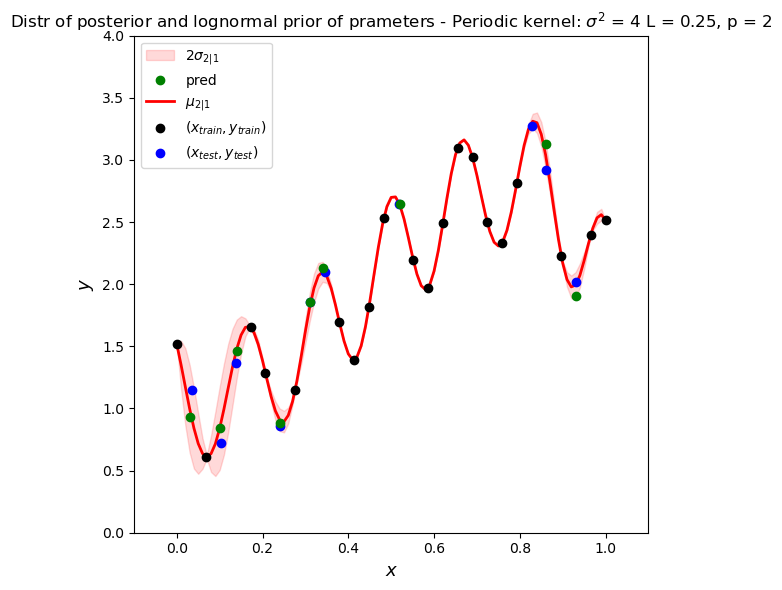

In [309]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(x, post_pred_periodic_opt, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(x[indices], post_pred_periodic_opt[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and lognormal prior of prameters - Periodic kernel: $\sigma^2$ = ' 
              + str(round(opt_par[0])) + " L = " +str(round(opt_par[1],2))  +", p = " + str(round(opt_par[2])))
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.savefig('Periodic_optimized_wpri.png')
plt.show()

## Local Periodic Kernel Plain

## Local Periodic Kernel Optim - without prior

In [17]:
# sigma2, lp, p, leq

kernel = local_periodic
ranges = ((1.e-4,1.e-1), (1.e-4,6), (0.1, 1), (1.e-4,2), (1.e-4,10))
Ngrid = 5
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\997890366.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


optimized NLL=-3.0635383401045537
optimal params: 0.0001 [6.       0.55     1.00005  2.500075]


In [18]:
np.random.seed(0)

opt_par = eta

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train, y_train, x_test, local_periodic, opt_par, noise_var)


# Draw some samples of the posterior
y2_loc_per = np.random.multivariate_normal(mean=μ2, cov=Σ2)

x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train, y_train, x, local_periodic, opt_par, noise_var)
post_pred_LOCper_opt = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

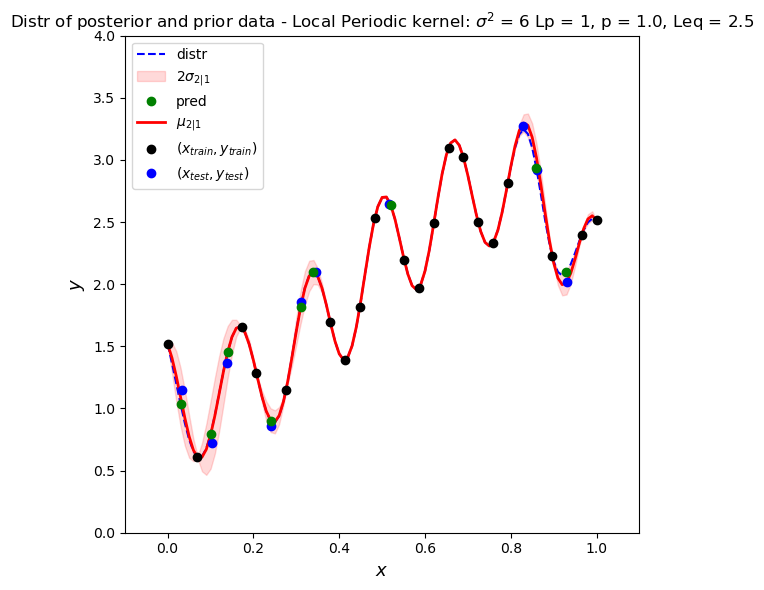

In [19]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(x, post_pred_LOCper_opt, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(x[indices], post_pred_LOCper_opt[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - Local Periodic kernel: $\sigma^2$ = ' 
              + str(round(opt_par[0])) + " Lp = " +str(round(opt_par[1]))  + ", p = " + str(round(opt_par[2],2))
              + ", Leq = "  + str(round(opt_par[3],2)))
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.show()

## Local Periodic Kernel opt - with prior (lognormality)

In [20]:
# ASSUME LOG-NORMALITY FOR THE FOUR PARAMETERS OF THE LOCAL PERIODIC: sigma2, lp, p, leq

# params of the Normal distribution

mus = np.array([0,0,0,0])
covmatr  = np.array([[.5, 0, 0, 0],[0, .3, 0, 0],[0, 0, .5, 0], [0, 0, 0, .2]])

norm_par = random.multivariate_normal(mus, covmatr, size=1)

# params of the lognormals:

m_ampl, v_ampl = np.exp(mus[0]+0.5*covmatr[0,0]), np.exp(2*mus[0]+covmatr[0][0])*(np.exp(covmatr[0][0])-1)
m_lp, v_lp = np.exp(mus[1]+0.5*covmatr[1][1]), np.exp(2*mus[1]+covmatr[1][1])*(np.exp(covmatr[1][1])-1)
m_per, v_per = np.exp(mus[2]+0.5*covmatr[2][2]), np.exp(2*mus[2]+covmatr[2][2])*(np.exp(covmatr[2][2])-1)
m_leq, v_leq = np.exp(mus[3]+0.5*covmatr[3][3]), np.exp(2*mus[3]+covmatr[3][3])*(np.exp(covmatr[3][3])-1)

# Log-normally distributed sample:

parameters = np.exp(norm_par)
lognorm_mu = np.array([m_ampl, m_lp, m_per, m_leq])
lognorm_cov = np.matrix([[v_ampl, 0, 0, 0],[0, v_lp, 0, 0],[0, 0, v_per, 0], [0, 0, 0, v_leq]])

In [21]:
kernel = local_periodic
ranges = ((1.e-4,1.e-1), (2,6), (0.1, 4), (1.e-4, 2), (0.1,4))
Ngrid = 5
noise_var, eta = optimize_params_second(ranges, kernel, Ngrid, lognorm_mu, lognorm_cov)
print("optimal params:", noise_var, eta)

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\997890366.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


optimized NLL=[[-2.04972085]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


In [22]:
np.random.seed(0)
opt_par = eta

domain = (-0.1, 1.1)
# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(x_train.reshape(-1,1), y_train, x_test.reshape(-1,1), local_periodic, opt_par, noise_var)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y_locpost_wpriors = np.random.multivariate_normal(mean=μ2, cov=Σ2)

x = np.linspace(0, 1, 101)
muu, sigmm = GP_noise(x_train, y_train, x, local_periodic, opt_par, noise_var)
post_pred_LOCper_opt_wpriors = np.random.multivariate_normal(mean=muu, cov=sigmm)
σ = np.sqrt(np.diag(sigmm))

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\997890366.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


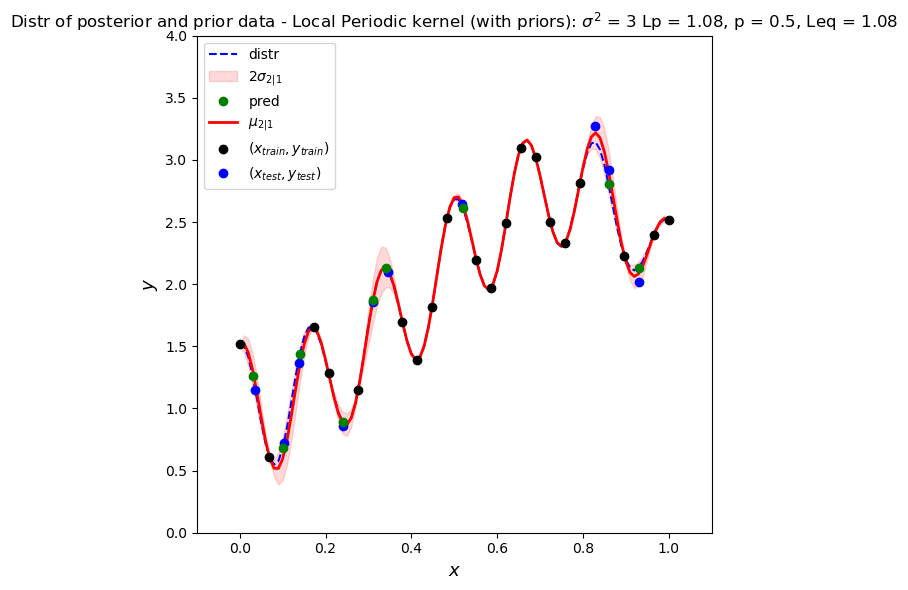

In [23]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(x, post_pred_LOCper_opt_wpriors, 'b--', label='distr')
ax1.fill_between(x.flat, muu-2*σ, muu+2*σ, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(x[indices], post_pred_LOCper_opt_wpriors[indices], 'og', zorder=10, label='pred')
ax1.plot(x, muu, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x_train, y_train, 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
ax1.plot(x_test, y_test, 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title(r'Distr of posterior and prior data - Local Periodic kernel (with priors): $\sigma^2$ = ' 
              + str(round(opt_par[0])) + " Lp = " +str(round(opt_par[1],2))  + ", p = " + str(round(opt_par[2],2))
              + ", Leq = "  + str(round(opt_par[3],2)))
ax1.axis([domain[0], domain[1], 0, 4])
ax1.legend()
plt.tight_layout()
plt.show()

# Point 5

In [24]:
xtrains = []
xtests = []
ytrains = []
ytests = []
indix = []

l = 30
vec = []
for i in range(1,31):
    xi = (i-1)/(l-1)
    vec.append(xi)
vec = np.array(vec)
finalgrid = np.meshgrid(vec, vec)

for k in range(20):
    np.random.seed(k)
    yi = func_g(vec) + np.random.normal(0,0.01,30)
    n = len(yi)
    
    train_indeces = random.choice(range(n), 20, replace=False)
    test_indeces = np.setdiff1d(range(n), train_indeces)
    x_train = vec[train_indeces]
    y_train = yi[train_indeces]
    
    x_test = vec[test_indeces]
    y_test = yi[test_indeces]

    xtrains.append(x_train)
    ytrains.append(y_train)
    xtests.append(x_test)
    ytests.append(y_test)

    x = np.linspace(0, 1, 101)
    indix.append(np.where(np.in1d(x, np.round(x_test,2)))[0])

C:\Users\Utente\AppData\Local\Temp\ipykernel_26032\997890366.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i,j] = abs


optimized NLL=[[-2.80993508]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


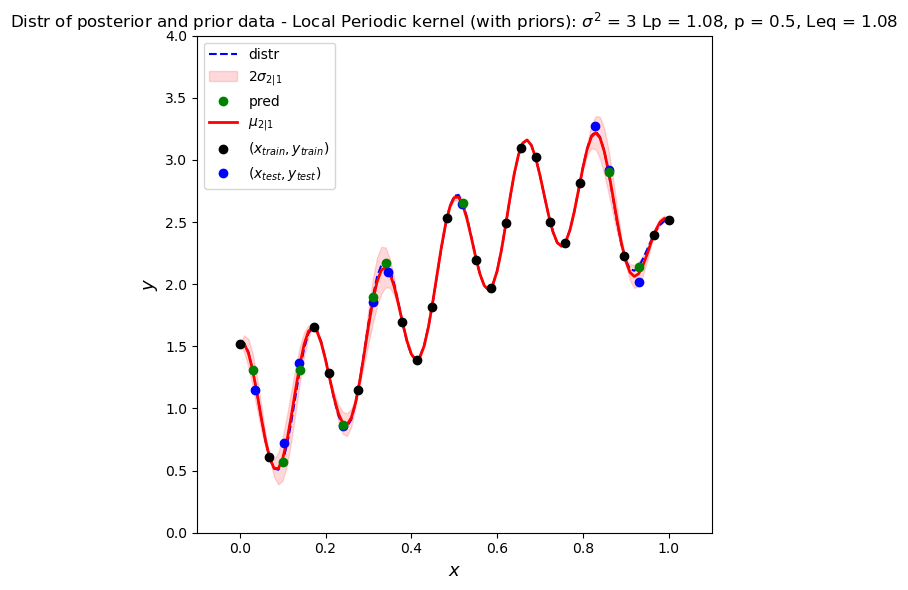

optimized NLL=[[-2.74220666]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


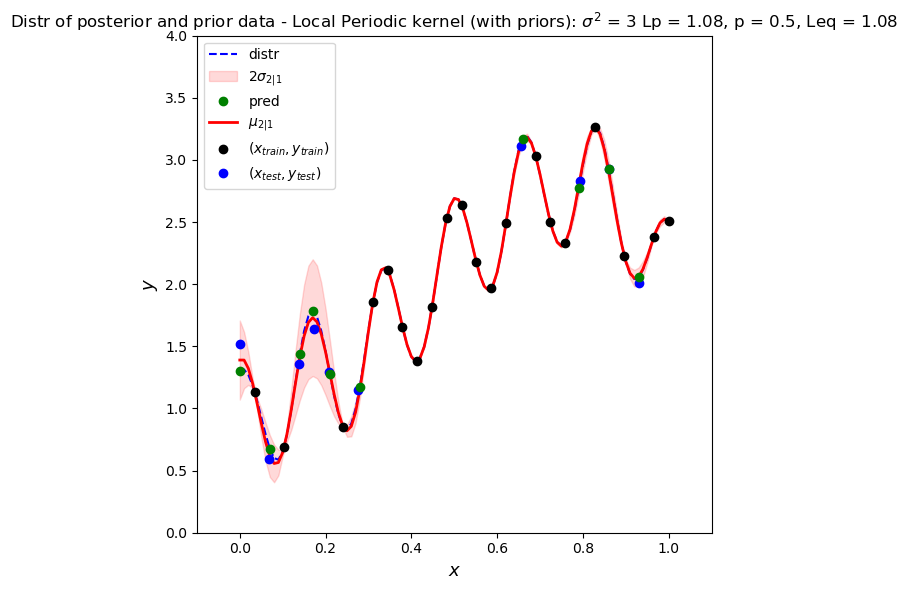

optimized NLL=[[-1.60974838]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


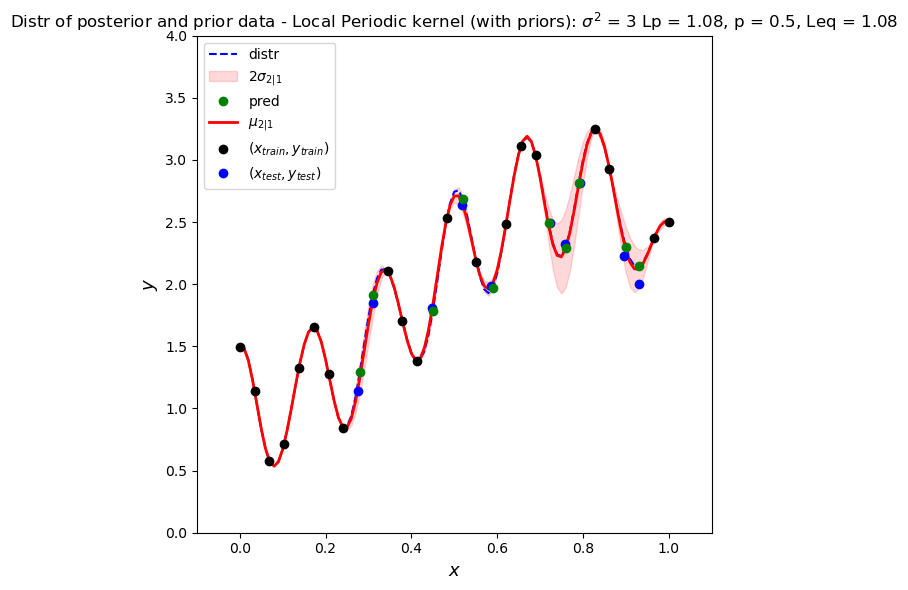

optimized NLL=[[-0.65940097]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


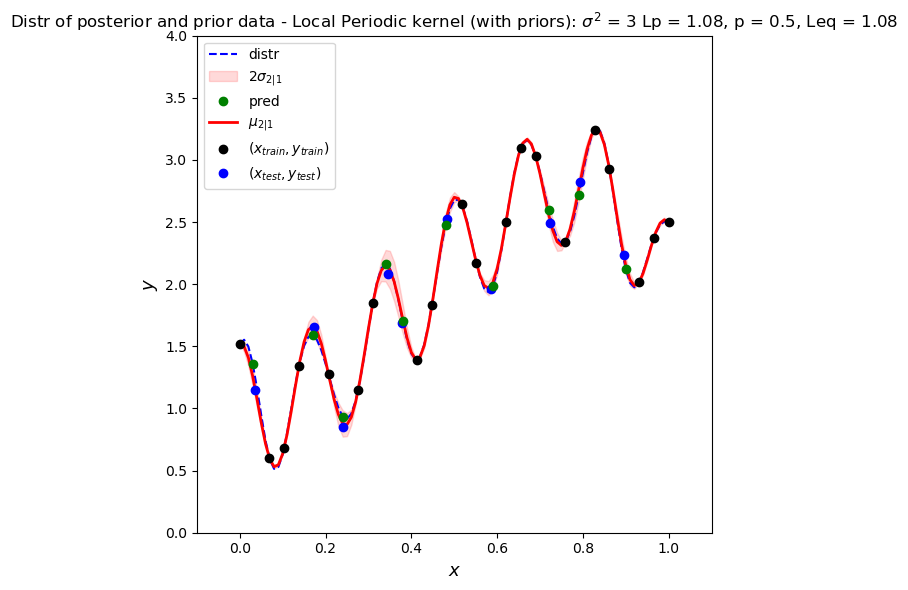

optimized NLL=[[-4.67226302]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


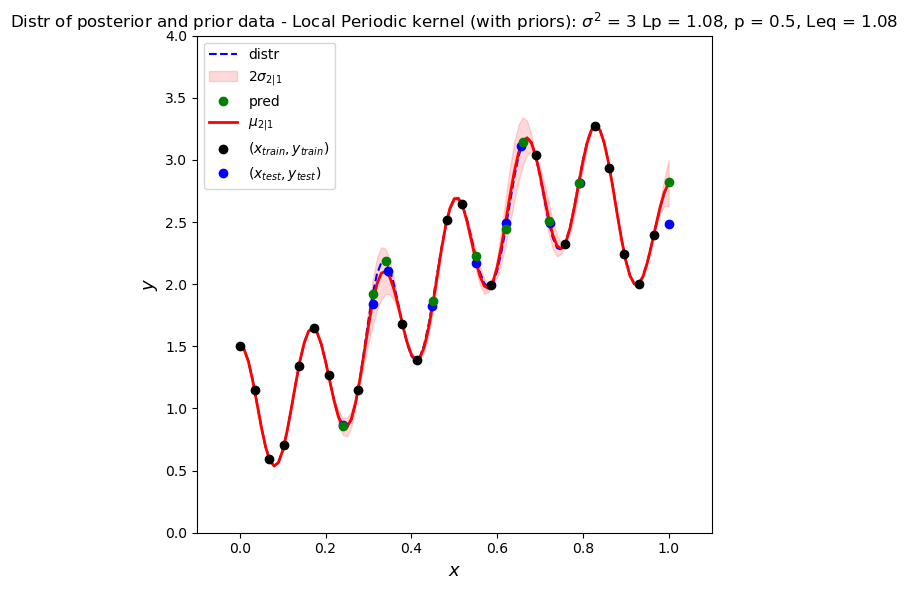

optimized NLL=[[-3.09622026]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


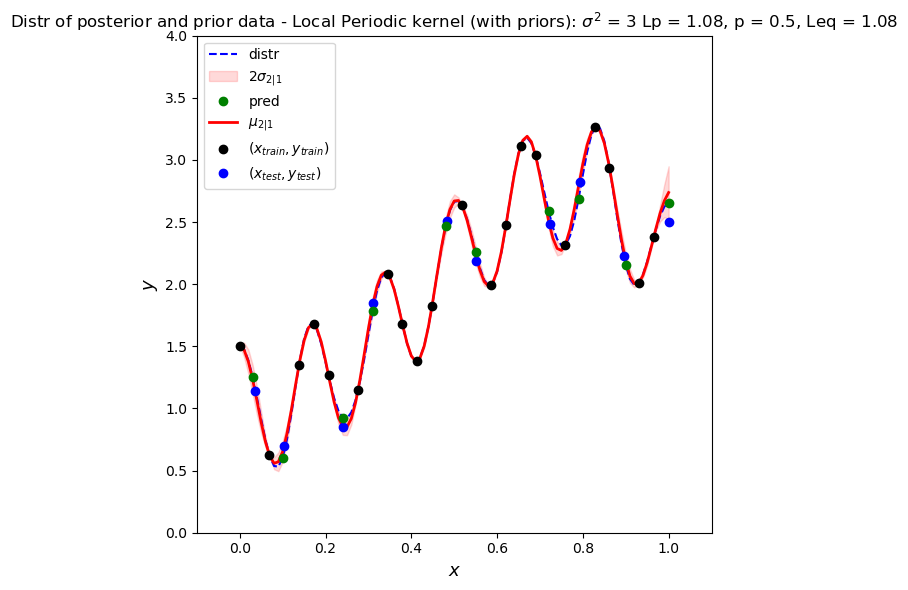

optimized NLL=[[-1.24446903]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


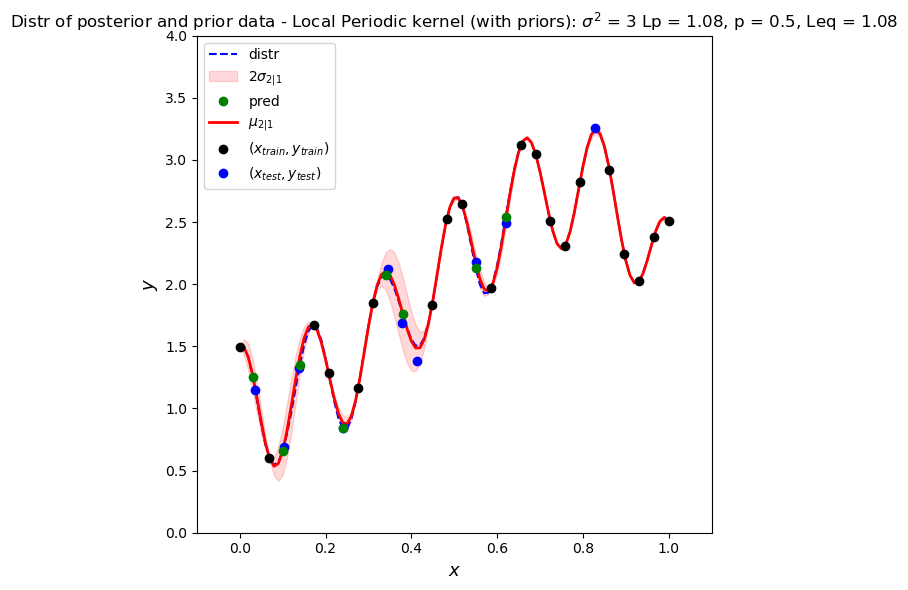

optimized NLL=[[-8.04157827]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


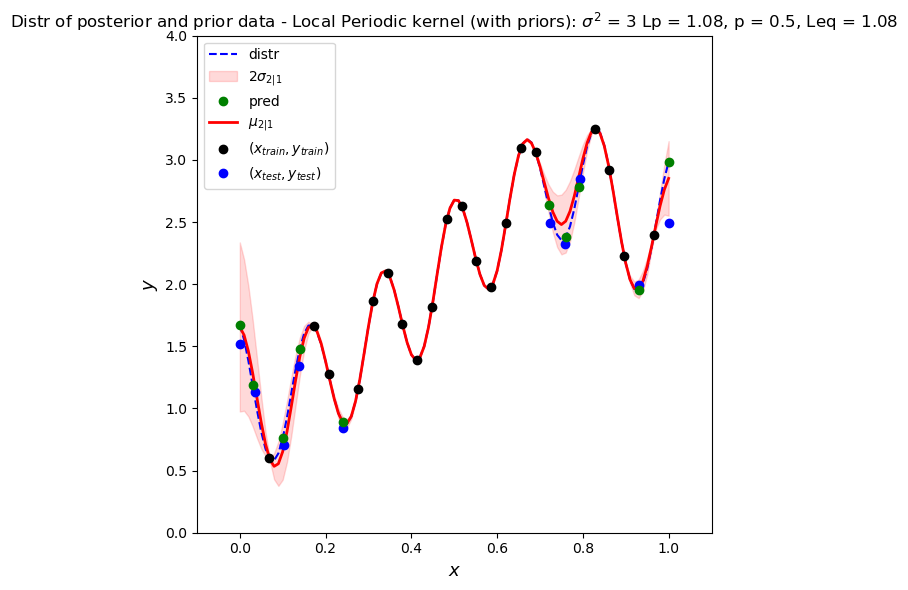

optimized NLL=[[-5.84227005]]
optimal params: 0.0001 [2.       1.075    0.500075 1.075   ]


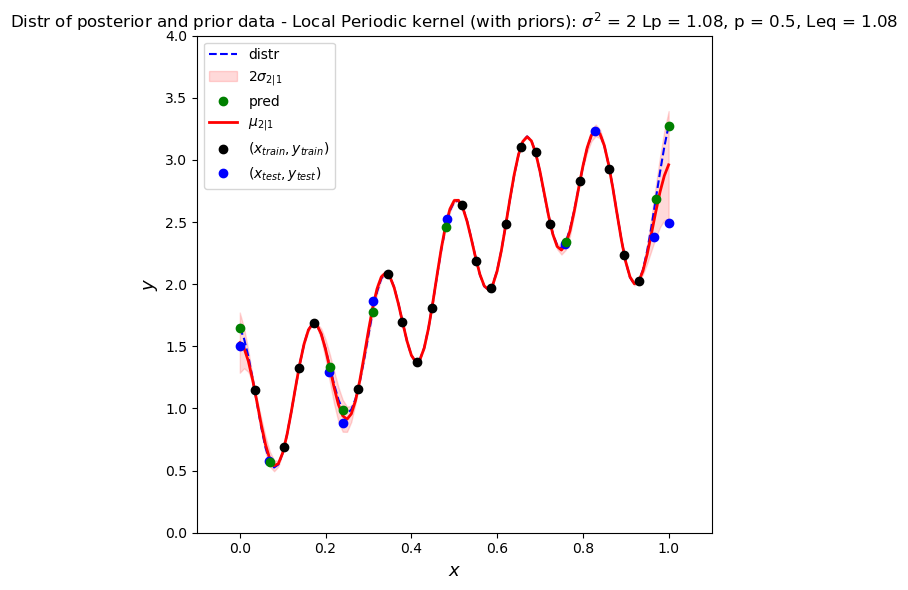

optimized NLL=[[-7.70493617]]
optimal params: 0.0001 [2.       1.075    0.500075 1.075   ]


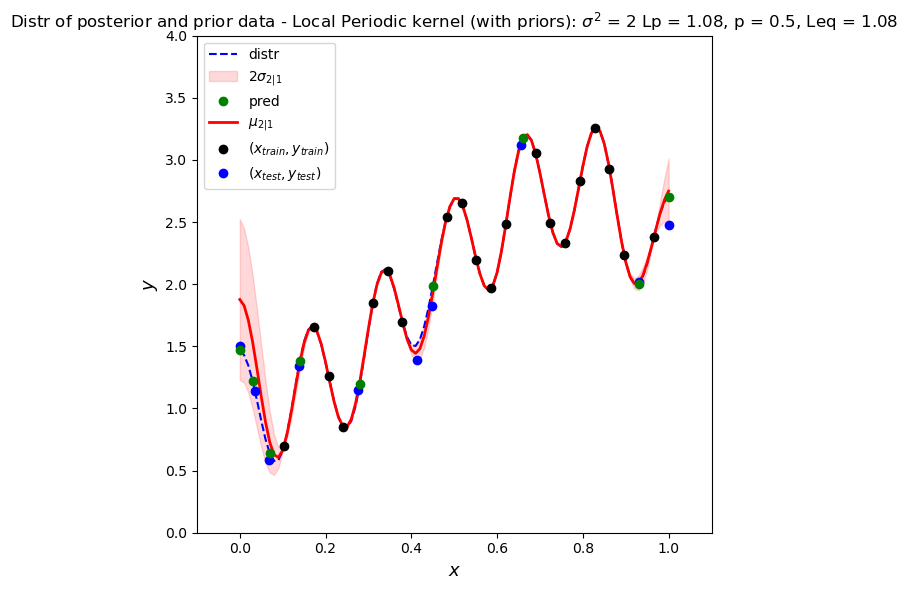

optimized NLL=[[-5.56031625]]
optimal params: 0.0001 [2.       1.075    0.500075 1.075   ]


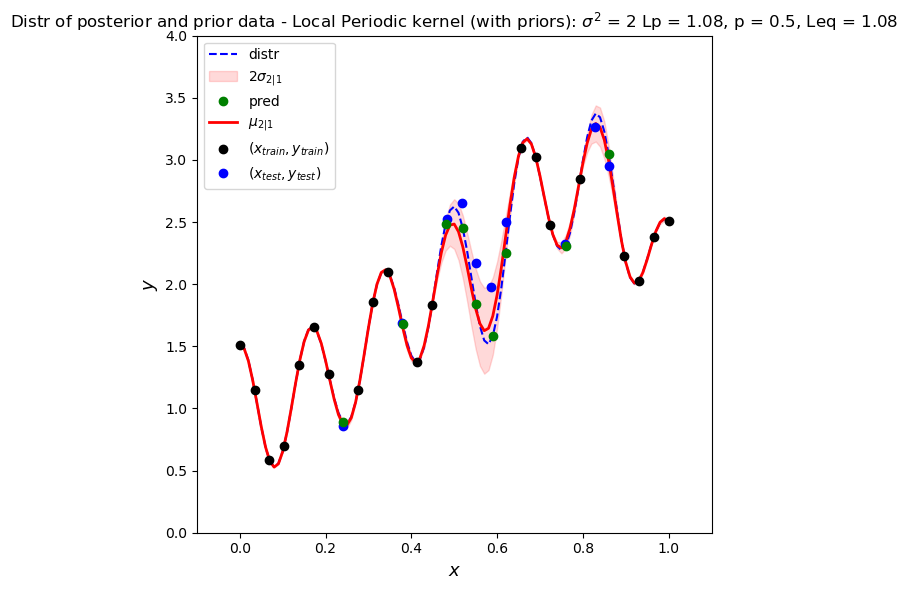

optimized NLL=[[-7.57657285]]
optimal params: 0.0001 [2.       1.075    0.500075 1.075   ]


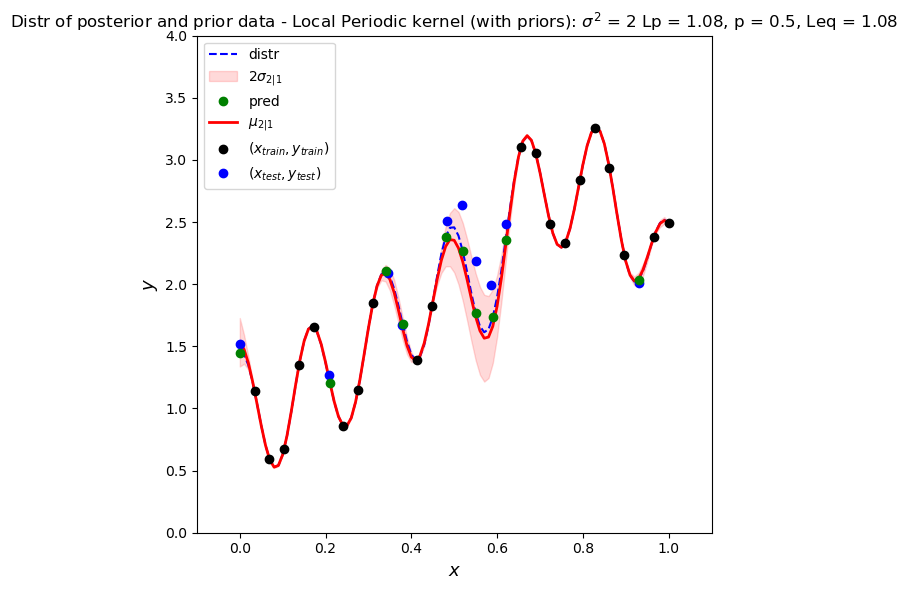

optimized NLL=[[-5.08785822]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


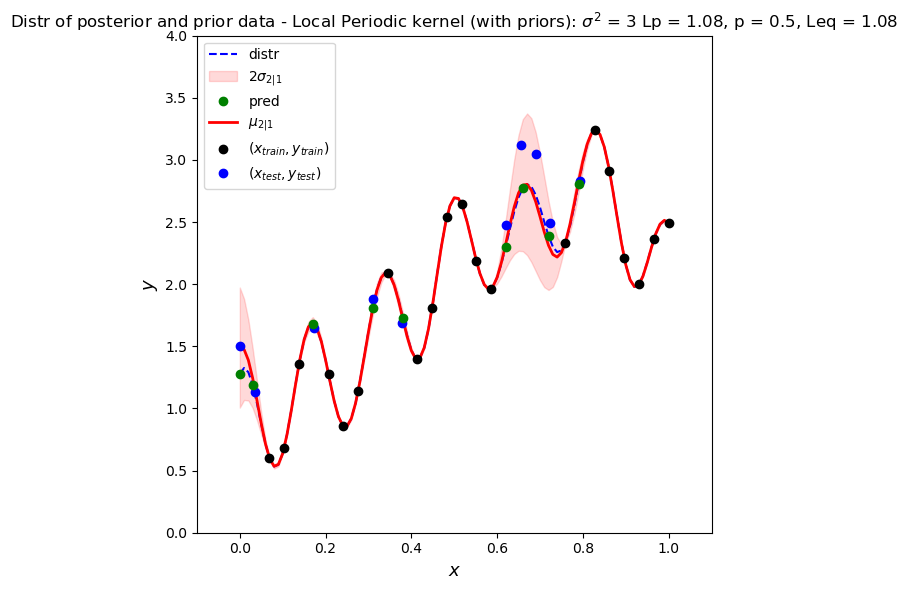

optimized NLL=[[-4.16003012]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


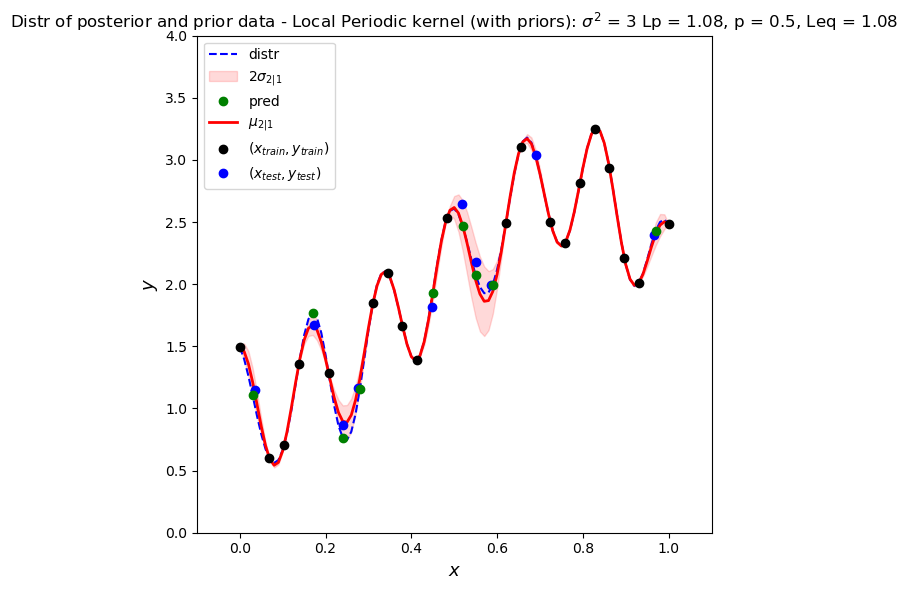

optimized NLL=[[-2.9606215]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


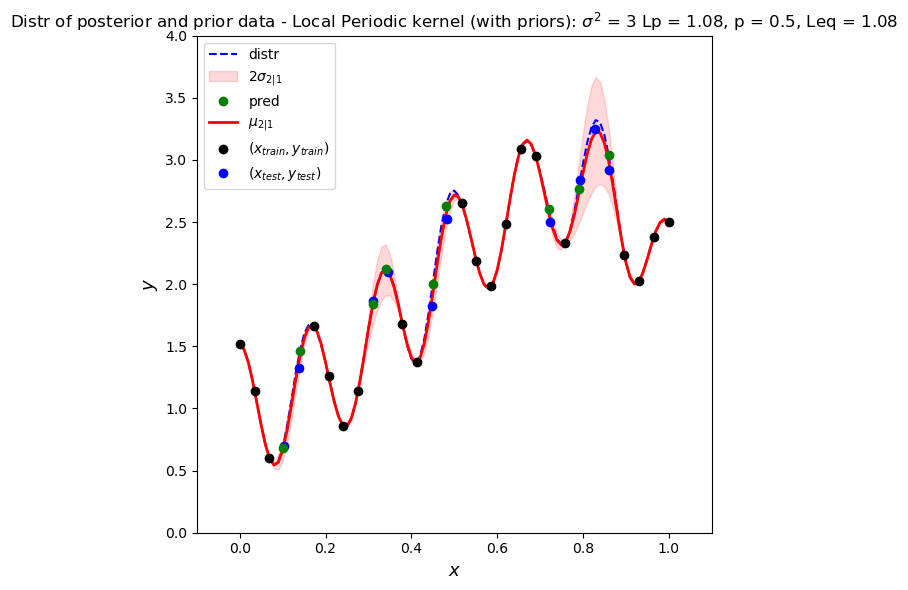

optimized NLL=[[-2.10641744]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


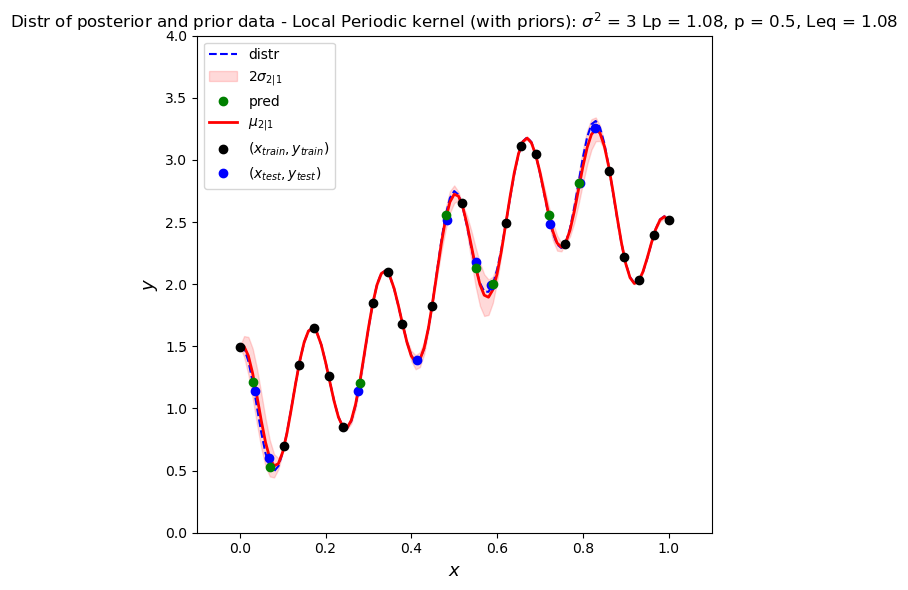

optimized NLL=[[-3.6281048]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


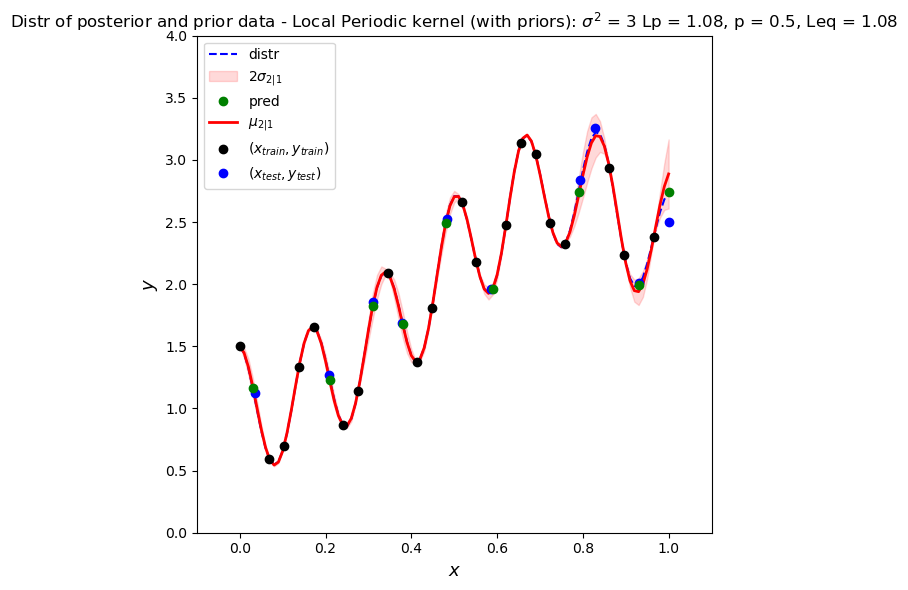

optimized NLL=[[-3.20351402]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


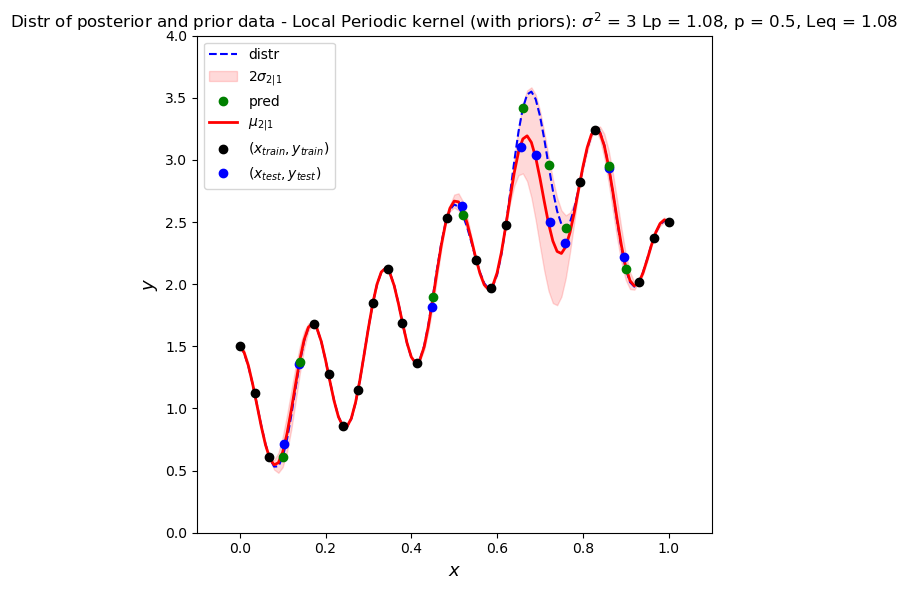

optimized NLL=[[-6.67550704]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


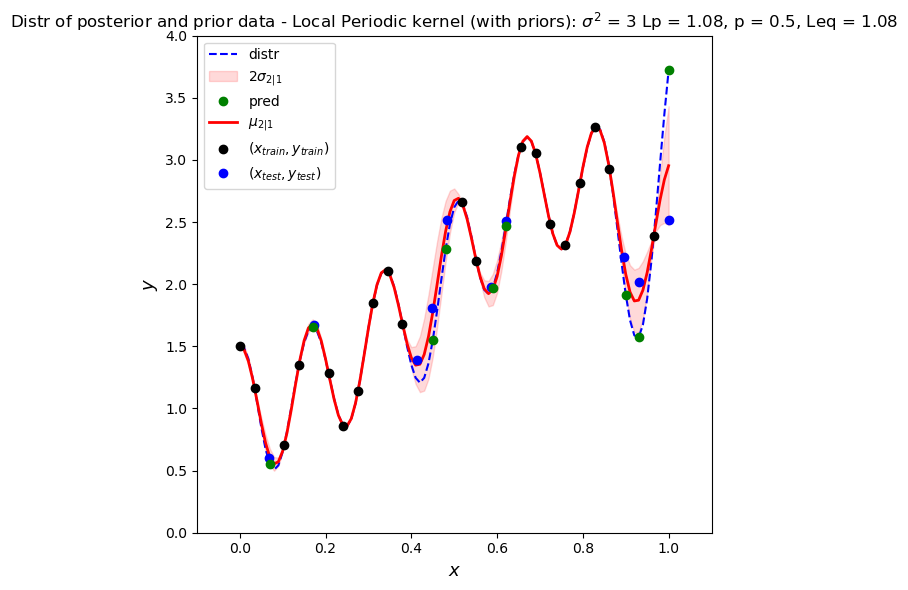

optimized NLL=[[-2.59765492]]
optimal params: 0.0001 [3.       1.075    0.500075 1.075   ]


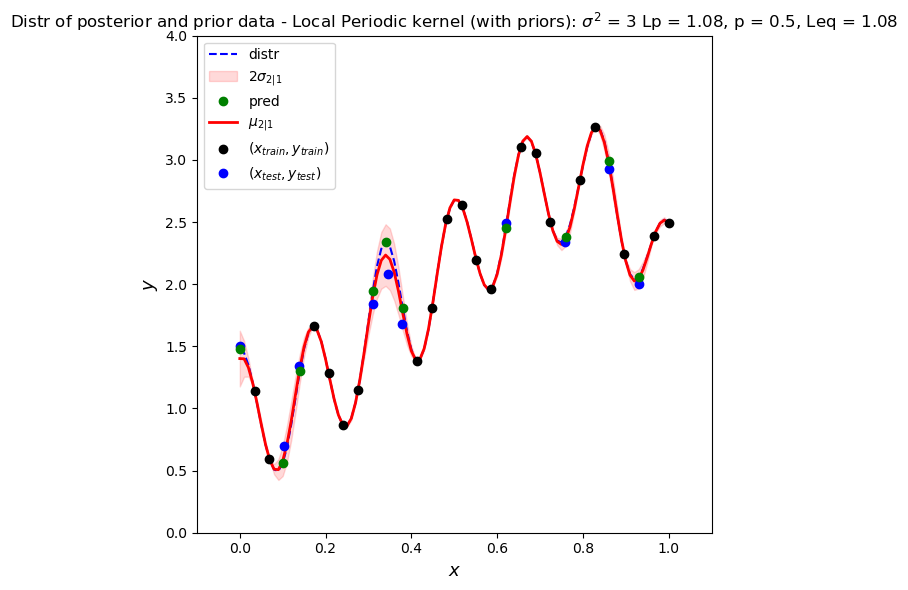

In [25]:
ypreds = []
testlikelihoods = []

for k in range(20):

    mus = np.array([0,0,0,0])
    covmatr  = np.array([[.5, 0, 0, 0],[0, .5, 0, 0],[0, 0, .5, 0], [0, 0, 0, .5]])
    norm_par = random.multivariate_normal(mus, covmatr, size=1)
    
    # params of the lognormals:
    
    m_ampl, v_ampl = np.exp(mus[0]+0.5*covmatr[0,0]), np.exp(2*mus[0]+covmatr[0][0])*(np.exp(covmatr[0][0])-1)
    m_lp, v_lp = np.exp(mus[1]+0.5*covmatr[1][1]), np.exp(2*mus[1]+covmatr[1][1])*(np.exp(covmatr[1][1])-1)
    m_per, v_per = np.exp(mus[2]+0.5*covmatr[2][2]), np.exp(2*mus[2]+covmatr[2][2])*(np.exp(covmatr[2][2])-1)
    m_leq, v_leq = np.exp(mus[3]+0.5*covmatr[3][3]), np.exp(2*mus[3]+covmatr[3][3])*(np.exp(covmatr[3][3])-1)
    
    # Log-normally distributed sample:
    
    parameters = np.exp(norm_par)
    lognorm_mu = np.array([m_ampl, m_lp, m_per, m_leq])
    lognorm_cov = np.matrix([[v_ampl, 0, 0, 0],[0, v_lp, 0, 0],[0, 0, v_per, 0], [0, 0, 0, v_leq]])

    def f_to_minimize_(params, kernel, S=xtrains[k], y=ytrains[k], means = lognorm_mu, vars = lognorm_cov):
        noise_y = params[0]    
        eta = params[1:]
        sigma_y_I = noise_y*np.eye(y.shape[0])
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], params = eta)
        n = y.shape[0]
        
        second_term = logprior(eta, means, vars)
        
        observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
        model_complexity = np.log(np.linalg.det(sigma_y_I+K))
        evidence = -1/2*observed_fit - 1/2*model_complexity 
        if np.isinf(evidence):
            return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
        return - evidence - second_term # NEGATIVE loglikelihood
    
    def optimize_params_second_(ranges, kernel, Ngrid):
        opt_params = scipy.optimize.brute(lambda params: f_to_minimize_(params, kernel), ranges, Ns=Ngrid, finish=None)
        noise_var = opt_params[0]
        eta = opt_params[1:]
        nll = f_to_minimize_(opt_params, kernel) # NOTE: added
        print(f"optimized NLL={nll}")
        return noise_var, eta, nll

    kernel = local_periodic
    ranges = ((1.e-4,1.e-1), (2,6), (0.1, 4), (1.e-4, 2), (0.1,4))
    
    Ngrid = 5
    noise_var, eta, testlik = optimize_params_second_(ranges, kernel, Ngrid)
    testlikelihoods.append(testlik)
    print("optimal params:", noise_var, eta)

    opt_par = eta
    domain = (-0.1, 1.1)
    
    x = np.linspace(0, 1, 101)
    μ2, Σ2 = GP_noise(xtrains[k], ytrains[k], x, local_periodic, opt_par, noise_var)
    Y_pred_local_periodic_wpriors = np.random.multivariate_normal(mean=μ2, cov=Σ2)
    σ = np.sqrt(np.diag(Σ2))

    ypreds.append(Y_pred_local_periodic_wpriors)

    x = np.linspace(0, 1, 101)

    indx = indix[k]
    fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
    # Plot the distribution of the function (mean, covariance)
    ax1.plot(x, Y_pred_local_periodic_wpriors, 'b--', label='distr')
    ax1.fill_between(x.flat, μ2-2*σ, μ2+2*σ, color='red', 
                     alpha=0.15, label='$2 \sigma_{2|1}$')
    ax1.plot(x[indx], Y_pred_local_periodic_wpriors[indx], 'og', zorder=10, label='pred')
    ax1.plot(x, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
    ax1.plot(xtrains[k], ytrains[k], 'ko', linewidth=2, label='$(x_{train}, y_{train})$')
    ax1.plot(xtests[k], ytests[k], 'o', linewidth=2, c="blue", label='$(x_{test}, y_{test})$')
    ax1.set_xlabel('$x$', fontsize=13)
    ax1.set_ylabel('$y$', fontsize=13)
    ax1.set_title(r'Distr of posterior and prior data - Local Periodic kernel (with priors): $\sigma^2$ = ' 
                  + str(round(opt_par[0])) + " Lp = " +str(round(opt_par[1],2))  + ", p = " + str(round(opt_par[2],2))
                  + ", Leq = "  + str(round(opt_par[3],2)))
    ax1.axis([domain[0], domain[1], 0, 4])
    ax1.legend()
    plt.tight_layout()
    plt.show()

In [26]:
np.mean(testlikelihoods)

-4.098981253161957

# B.2

### Point 3

In [10]:
np.random.seed(0)
qs = [0, 5, 10]

l = 101
wi = np.zeros(101)
for i in range(l):
    if i == 0 or i == 100:
        wi[i] = 1/(2*l -2)
    else:
        wi[i] = 1/(l-1)
vec = []
for i in range(l):
    vec.append((i-1)/(l-1))
x = np.array(vec)

yi = func_g(x) + np.random.normal(0, 0.01, l)

In [11]:
optimal = [1.9896, 0.46544, 0.99459] # from maximizing the ll with priors
noise = 0.00202

# Periodic kernel: params = [sigma2, l, p]

def periodic(xa, xb, params):
    sigma2, l, p = params[0], params[1], params[2]
    mat = np.zeros((len(xa), len(xb)))
    for i in range(len(xa)):
        for j in range(len(xb)):
            abs = np.abs(xa[i] - xb[j])
            mat[i,j] = abs
    return sigma2 * np.exp(-2/l**2 * (np.sin(np.pi * mat/p)**2))

In [12]:
# Gaussian process conditioning on q
def GP_2(X1, qs, X2, weights, kernel_func, params, noise):
       
    σ_noise=noise
    # Kernel of the noisy observations
    n1 = X1.shape[0]
    
    
    Σ11 = np.array(weights.T @ kernel_func(X1, X1, params).T @ weights).reshape(1,1)
    Σ22 = kernel_func(X2, X2, params)   
    # Kernel of observations vs to-predict
    Σ21 = (weights.T @ kernel_func(X1, X2, params)).reshape(n1,1)  
    Σ12 = (kernel_func(X2, X1, params) @ weights).reshape(1, n1)  
    
    # Compute posterior mean
    
    μ1 = Σ21 @ np.linalg.inv(Σ11) * qs
    Σ1 = Σ22 - (Σ21 @ np.linalg.inv(Σ11) @ Σ12)
    
    return μ1, Σ1  # mean, covariance

In [13]:
np.random.seed(2024)

fs = []
for i in range(3):
    m, s = GP_2(x, qs[i], x, wi, periodic, optimal, noise)
    f = np.random.multivariate_normal(mean=m.flatten(), cov=s, size=5)
    fs.append(f)

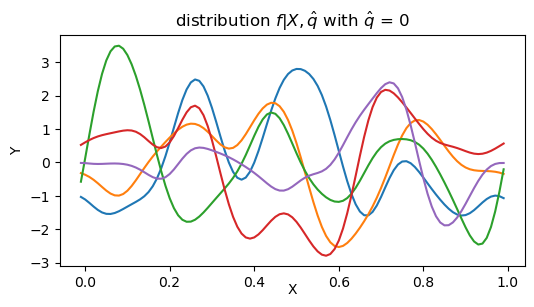

In [14]:
figure(figsize=(6, 3))
plt.plot(x, fs[0][0].reshape(101,))
plt.plot(x, fs[0][1].reshape(101,))
plt.plot(x, fs[0][2].reshape(101,))
plt.plot(x, fs[0][3].reshape(101,))
plt.plot(x, fs[0][4].reshape(101,))
plt.title(r'distribution $f|X,\hat{q}$ with $\hat{q}$ = ' + str(np.round(qs[0],2)))
plt.xlabel("X", labelpad=-5)
plt.ylabel("Y")
plt.savefig('pointB2_3_0.png')
plt.show()

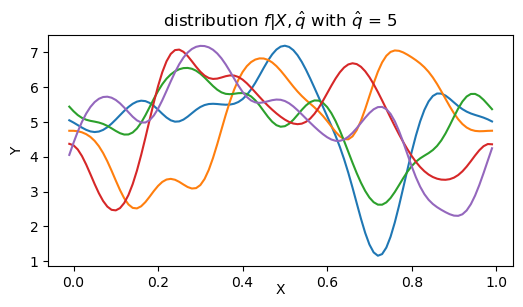

In [15]:
figure(figsize=(6, 3))
plt.plot(x, fs[1][0].reshape(101,))
plt.plot(x, fs[1][1].reshape(101,))
plt.plot(x, fs[1][2].reshape(101,))
plt.plot(x, fs[1][3].reshape(101,))
plt.plot(x, fs[1][4].reshape(101,))
plt.title(r'distribution $f|X,\hat{q}$ with $\hat{q}$ = ' + str(np.round(qs[1],2)))
plt.xlabel("X", labelpad=-5)
plt.ylabel("Y")
plt.savefig('pointB2_3_5.png')

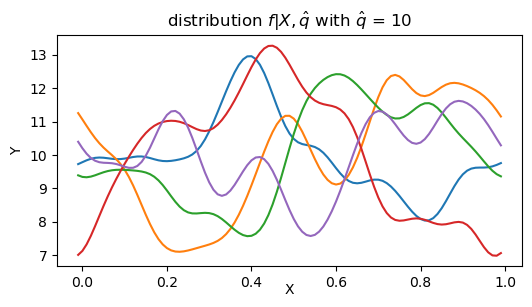

In [16]:
figure(figsize=(6, 3))
plt.plot(x, fs[2][0].reshape(101,))
plt.plot(x, fs[2][1].reshape(101,))
plt.plot(x, fs[2][2].reshape(101,))
plt.plot(x, fs[2][3].reshape(101,))
plt.plot(x, fs[2][4].reshape(101,))
plt.title(r'distribution $f|X,\hat{q}$ with $\hat{q}$ = ' + str(np.round(qs[2],2)))
plt.xlabel("X", labelpad=-5)
plt.ylabel("Y")
plt.savefig('pointB2_3_10.png')

### Point 4

In [17]:
Dx = np.array([0, 0.25, 0.5])
Dy = np.array([1.46, 0.93, 2.76])

In [18]:
# Gaussian process posterior with noisy obeservations
def GP(X1, y1, X2, kernel_func, params, noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    σ_noise=noise
    n1 = X1.shape[0]
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1, params) + ((σ_noise ** 2) * np.eye(n1))
    
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, params)
    Σ21 = Σ12.T #kernel_func(X2, X1, params)
     
    # Compute posterior mean
    μ1 = Σ21 @ np.linalg.inv(Σ11) @ y1
    # Compute the posterior covariance
    
    Σ22 = kernel_func(X2, X2, params)
    
    Σ1 = Σ22 - (Σ21 @ np.linalg.inv(Σ11) @ Σ12)
    
    return μ1, Σ1  # mean, covariance

In [19]:
def GP_constr(xtr, xte, ytr, kernel, params, weights, constraint, noise):
    
    mean_fstar = kernel(xtr, xte, params).T @ np.linalg.inv(kernel(xtr, xtr, params) + noise*np.eye(3)) @ ytr
    var_fstar = kernel(xte, xte, params) - kernel(xtr, xte, params).T @ np.linalg.inv(kernel(xtr, xtr, params) + noise*np.eye(3)) @ kernel(xtr, xte, params)

    mu_final = var_fstar @ weights @ np.linalg.inv(weights.T @ var_fstar.T @ weights) @ constraint
    Sig_final = var_fstar - var_fstar @ weights @ np.linalg.inv(weights.T @ var_fstar.T @ weights) @ (var_fstar @ weights).T
    
    return mu_final, Sig_final
    #return mu1.flatten(), d1

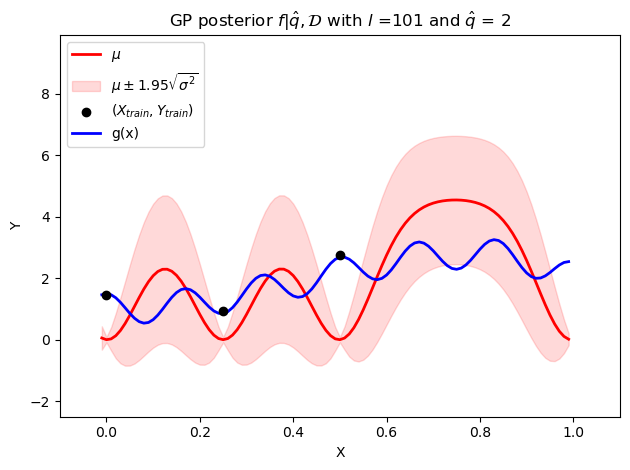

In [20]:
np.random.seed(1)

q= np.array([2])
wi = np.array([1/(2*l-2) if i in [1,l] else 1/(l-1) for i in range(1,l+1)]).reshape(l,1)

mu1, d1 = GP_constr(Dx, x, Dy, periodic, optimal, wi, q, noise)
#f1 = np.random.multivariate_normal(mean=mu1.flatten(), cov=d1, size=1)
std1 = np.sqrt(np.diag(d1))

plt.plot(x, mu1, 'r-', lw=2, label=r'$\mu$')
plt.fill_between(x.flat, mu1-1.95*std1, mu1+1.95*std1, color='red', 
                 alpha=0.15, label=r'$\mu \pm 1.95\sqrt{\sigma^2}$')
plt.scatter(Dx, Dy, c="k", zorder=10, label='($X_{train}, Y_{train}$)')
plt.plot(x, func_g(x), 'b-', lw=2, label=r'g(x)')

plt.title(r'GP posterior $f|\hat{q}, \mathcal{D}$ with $\mathit{l}$ =' + 
            str(l) +" and " +r'$\hat{q}$ = 2')
plt.xlabel("X")
plt.ylabel("Y")
plt.axis([-0.1, 1.1, -2.5, np.max(mu1+5*std1)])
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('point4_with_const.png')
plt.show()

In [21]:
np.trapz(mu1, x)

2.0

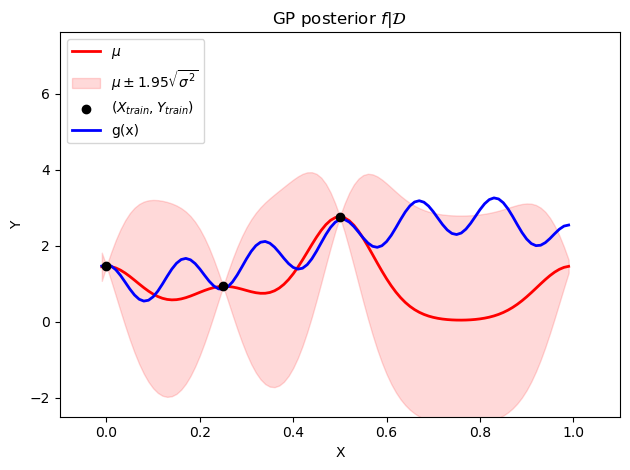

In [22]:
np.random.seed(0)

#optimal = [3, 1.075, 0.500075, 1.075] # from maximizing the ll with priors from B1
#noise = 0.0001

postmean, postvar = GP(Dx,Dy, x, periodic, optimal, noise)
f2 = np.random.multivariate_normal(mean=postmean, cov=postvar, size=1)
std2 = np.sqrt(np.diag(postvar))

plt.plot(x, postmean, 'r-', lw=2, label=r'$\mu$')
plt.fill_between(x.flat, postmean-1.95*std2, postmean+1.95*std2, color='red', 
                 alpha=0.15, label=r'$\mu \pm 1.95\sqrt{\sigma^2}$')
plt.scatter(Dx, Dy, c="k", zorder=10, label='($X_{train}, Y_{train}$)')
plt.plot(x, func_g(x), 'b-', lw=2, label=r'g(x)')

plt.title(r'GP posterior $f|\mathcal{D}$')
plt.xlabel("X")
plt.ylabel("Y")
plt.axis([-0.1, 1.1, -2.5, np.max(postmean+5*std2)])
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('point4_no_const.png')
plt.show()